In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes.utils import *
from lifetimes import BetaGeoFitter,GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix, plot_period_transactions, plot_cumulative_transactions,plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions,plot_history_alive

orders = pd.read_csv("olist_orders_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
cust = pd.read_csv("olist_customers_dataset.csv")

In [3]:
print(cust.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


In [4]:
#how many unique purchases are made by different customers
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
17        1
9         1
dtype: int64

In [5]:
orders = pd.merge(orders,cust[['customer_id','customer_unique_id']],on='customer_id')
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id'],
      dtype='object')

In [6]:
print(items.columns)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [7]:
#keep the first item from each order because the price column is total amount of money from order not particular item
items.drop_duplicates('order_id',keep='first',inplace=True)

In [8]:
transaction_data = pd.merge(orders,items,'inner','order_id')
transaction_data = transaction_data[['customer_unique_id','order_purchase_timestamp','price']]

## convert timestamp to date; only need the day
transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp',axis=1)
transaction_data.head()

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24
2,3a653a41f6f9fc3d2a113cf8398680e8,159.90,2018-08-08
3,7c142cf63193a1473d2e66489a9ae977,45.00,2017-11-18
4,72632f0f9dd73dfee390c9b22eb56dd6,19.90,2018-02-13


In [9]:
summary = summary_data_from_transaction_data(transaction_data,'customer_unique_id','date',monetary_value_col='price',)
summary.describe()
#summary.head()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [10]:
#to see customers who have bought more than once.
#frequency = number of days a customer made a repeat purchase
#recency = customer age in days at time of most recent purchase 
#T = customer's age in days 
#monetary_value = mean of customers purchases excluding first purchase
summary[summary['frequency']>0].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.90
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.00
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.58
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.55
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.90


In [11]:
transaction_data[transaction_data['customer_unique_id']=='004288347e5e88a27ded2bb23747066c']

,customer_unique_id,price,date
33396,004288347e5e88a27ded2bb23747066c,229.99,2017-07-27
39730,004288347e5e88a27ded2bb23747066c,87.90,2018-01-14


# BG/NBD MODEL FOR CUSTOMER CHURN 

Assumptions of the BG/NBD model:
A customer’s relationship has two phases: “alive” for an unobserved period of time, then “dead”
While alive, the number of transactions made by a customer follows a Poisson distribution with transaction rate lambda
Heterogeneity in lambda follows a gamma distribution
After any transaction, a customer dies with probability p; the probability that a customer dies after a number of transactions follows a geometric distribution
p follows a beta distribution
Lambda and p vary independently across customers

In [12]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T']);

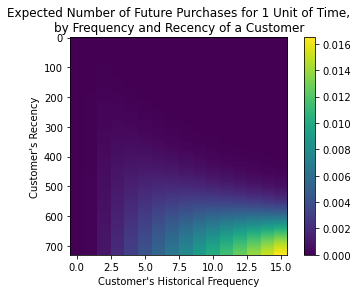

In [13]:
plot_frequency_recency_matrix(bgf);
plt.show()

C:\Users\Hewitt\Anaconda3\lib\site-packages\lifetimes\plotting.py:259: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


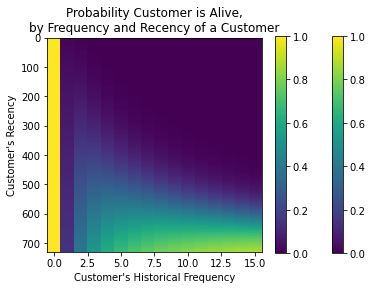

In [15]:
plot_probability_alive_matrix(bgf);
plt.show()

# training the model and evaluating performance

1) Calibration period histogram: does the model fit the training data?
2) Cumulative transaction plot: does the model predict cumulative sales well?
3) Incremental transaction plot: does the model capture the overall trend in transactions?
4) Conditional expectations plot: can the model predict the number of purchases a customer will make based on the training data?

C:\Users\Hewitt\Anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


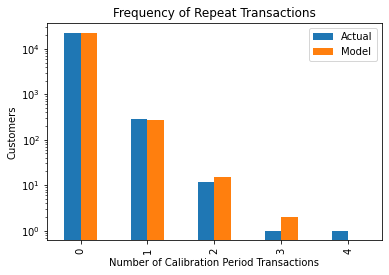

In [31]:
plot_period_transactions(bgf).set_yscale('log');
plt.show()

In [18]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',calibration_period_end='2017-09-03', observation_period_end='2018-09-03' )

In [19]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);

In [28]:
t = 1
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').head(50)

,frequency,recency,T,monetary_value,predicted_purchases
customer_unique_id,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,476.0,47.642000,0.023290
1b6c7548a2a1f9037c1fd3ddfed95f33,6.0,93.0,294.0,97.831667,0.000153
ca77025e7201e3b30c44b472ff346268,6.0,235.0,329.0,66.126667,0.004491
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,429.0,75.552000,0.006601
63cfc61cee11cbe306bff5857d00bfe4,5.0,382.0,480.0,62.772000,0.003750
...,...,...,...,...,...
5610b0083f65fb633e300f6a55916292,0.0,0.0,196.0,0.000000,0.000049
56100e0916fa960a7b6ef5d598130ed4,0.0,0.0,185.0,0.000000,0.000051
560fc03b072c345ebe220ee6d9e2c7f9,0.0,0.0,178.0,0.000000,0.000053


lets model churn risk . Customers with only 1 purchase have 100% probability of being alive because it starts after customer birth which is the first purchase. So we only consider customers who have made at least one repeat purchse to model churn risk


In [37]:
dataset = summary[summary ['frequency']>0]
dataset['probability_alive'] = bgf.conditional_probability_alive(dataset['frequency'], dataset['recency'],dataset['T']) 


In [34]:
dataset

,frequency,recency,T,monetary_value,predicted_purchases,probability_alive
customer_unique_id,,,,,,
004288347e5e88a27ded2bb23747066c,1.0,171.0,403.0,87.900,0.000122,0.053200
004b45ec5c64187465168251cd1c9c2f,1.0,267.0,367.0,27.000,0.000205,0.082272
0058f300f57d7b93c477a131a59b36c3,1.0,31.0,196.0,72.580,0.000145,0.033793
00a39521eb40f7012db50455bf083460,1.0,11.0,103.0,11.550,0.000282,0.039748
011575986092c30523ecb71ff10cb473,1.0,60.0,198.0,63.900,0.000200,0.046973
...,...,...,...,...,...,...
fed519569d16e690df6f89cb99d4e682,1.0,88.0,257.0,89.900,0.000165,0.048216
ff03923ad1eb9e32304deb7f9b2a45c9,1.0,33.0,133.0,110.320,0.000276,0.047044
ff22e30958c13ffe219db7d711e8f564,1.0,10.0,10.0,145.000,0.002183,0.106628


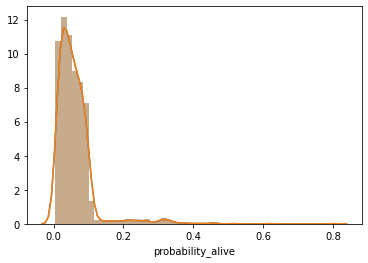

In [39]:
sns.distplot(dataset['probability_alive']);
plt.show()